In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import data
from IPython.display import HTML
import myWidgets
import logisticRegression
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import Model
import ModelTracker

df = data.get_data()
tracker = ModelTracker.ModelTracker()

Le but de ce projet est de construire un modèle de prédiction simple afin de me familiariser avec les concepts de base d'intelligence artificielle. 

Le projet va devoir prédire quels clients sont plus susceptibles d'acheter une assurance caravane en fonction des données provenant du CoIL 2000 Challenge. 

Les variables qui commence par M sont des variables qui donne de l'information sur la distribution de la variable dans le zipcode area du client. (0 = aucun, 9 = beaucoup). Ce n'est pas une zone!

In [3]:
display(myWidgets.AllVarComparator(df.columns, df).get_widget())

In [4]:
corr_discrete = df.corr(method='spearman').loc[['CARAVAN']].sort_values(by='CARAVAN', axis=1, ascending=False).drop(columns=['CARAVAN'])
corr_top = corr_discrete.unstack().sort_values(ascending=False) #2d a 1d (A,B)
corr_combined = corr_discrete.style.background_gradient(cmap='coolwarm', axis=None).format(precision=4)

display(HTML(corr_combined.to_html()))


,PPERSAUT,APERSAUT,APLEZIER,PPLEZIER,PBRAND,MINKGEM,PWAPART,MKOOPKLA,AWAPART,MHKOOP,MOPLHOOG,MAUT1,MINK4575,ABRAND,ABYSTAND,MRELGE,PBYSTAND,MINK7512,MSKA,MBERHOOG,MZPART,MBERMIDD,MOPLMIDD,MGEMOMV,MGODPR,PGEZONG,AGEZONG,MSKB1,PWAOREG,AWAOREG,AFIETS,MFWEKIND,PFIETS,MBERZELF,AZEILPL,PZEILPL,MGODRK,ALEVEN,AINBOED,PINBOED,PLEVEN,PAANHANG,AAANHANG,AMOTSCO,PMOTSCO,MAUT2,MFGEKIND,MSKB2,MINK123M,MGODOV,MGEMLEEF,AWABEDR,PWABEDR,MAANTHUI,MINK3045,PBESAUT,ABESAUT,APERSONG,PPERSONG,AVRAAUT,PVRAAUT,PWERKT,AWERKT,PTRACTOR,ATRACTOR,AWALAND,PWALAND,MRELSA,MGODGE,ABROM,PBROM,MSKC,MBERARBG,MFALLEEN,MZFONDS,MBERBOER,MBERARBO,MOSTYPE,MRELOV,MSKD,MOSHOOFD,MAUT0,MHHUUR,MINKM30,MOPLLAAG
CARAVAN,0.1637,0.1495,0.1064,0.1064,0.1006,0.1002,0.0953,0.0947,0.0900,0.0799,0.0782,0.0734,0.0699,0.0695,0.0682,0.0682,0.0681,0.0632,0.0600,0.0572,0.0554,0.0410,0.0399,0.0355,0.0348,0.0337,0.0335,0.0309,0.0303,0.0303,0.0289,0.0287,0.0287,0.0266,0.0262,0.0262,0.0196,0.0193,0.0191,0.0190,0.0186,0.0146,0.0145,0.0103,0.0099,0.0084,0.0075,0.0073,0.0072,0.0041,0.0039,0.0006,0.0006,-0.0011,-0.0063,-0.0069,-0.0070,-0.0085,-0.0085,-0.0099,-0.0099,-0.0152,-0.0152,-0.0165,-0.0167,-0.0213,-0.0213,-0.0274,-0.0414,-0.0452,-0.0452,-0.0485,-0.0508,-0.0517,-0.0562,-0.0565,-0.0572,-0.0580,-0.0581,-0.0611,-0.0615,-0.0775,-0.0806,-0.0815,-0.0907


Les 10 variables les plus correlated avec la cible sont :

In [240]:
data.top_index_and_values(10 ,corr_top)

Contribution car policies                          PPERSAUT   - 0.1637
Number of car policies                             APERSAUT   - 0.1495
Number of boat policies                            APLEZIER   - 0.1064
Contribution boat policies                         PPLEZIER   - 0.1064
Contribution fire policies                         PBRAND     - 0.1006
Average income                                     MINKGEM    - 0.1002
Contribution private third party insurance see L4  PWAPART    - 0.0953
Purchasing power class                             MKOOPKLA   - 0.0947
Number of private third party insurance 1 - 12     AWAPART    - 0.0900
Home owners                                        MHKOOP     - 0.0799


In [241]:
categorical_vars, discrete_vars = data.get_var_by_types(df)
discrete_vars.remove('CARAVAN')

df_encoded = pd.get_dummies(df, columns=categorical_vars, prefix=categorical_vars, dtype=int)
print(df_encoded.dtypes)


MAANTHUI       int64
MGEMOMV        int64
MGEMLEEF       int64
MGODRK         int64
MGODPR         int64
               ...  
MOSHOOFD_6     int64
MOSHOOFD_7     int64
MOSHOOFD_8     int64
MOSHOOFD_9     int64
MOSHOOFD_10    int64
Length: 134, dtype: object


(2025-11-12)
J'ai oublier de one-hot code les variables MOSHOOFD et MOSTYPE. Elles sont categorique, mais pas ordinale. Mes résultats sont pas mal différents maintenant.

In [243]:
X = df_encoded.drop('CARAVAN', axis=1) 
y = df_encoded['CARAVAN']  #targets

X_train, X_val, y_train, y_val = data.get_split_train_eval_data(df_encoded)

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_val_np = X_val.to_numpy()
y_val_np = y_val.to_numpy()

In [244]:
w,b = logisticRegression.logistic_regression(X_train_np, y_train_np)

Iteration 0: Cost = 0.6931471805599452
Iteration 100: Cost = 0.2153636686007336
Iteration 200: Cost = 0.21049395901189408
Iteration 300: Cost = 0.2080377100140786
Iteration 400: Cost = 0.20659973578995866
Iteration 500: Cost = 0.2056581102317727
Iteration 600: Cost = 0.20498405318644572
Iteration 700: Cost = 0.20446697987594464
Iteration 800: Cost = 0.20404888252915487
Iteration 900: Cost = 0.20369711341448316


In [245]:
threshold = 0.1 #trop bas
model = Model.Model(w, b, threshold)
tracker.add(model)
model.print_stats(X_val_np, y_val_np)

Model v1 saved

Threshold:  0.1
Accuracy:  0.8171673819742489
[[915 180]
 [ 33  37]]
AUC:  0.7950554468362687


Présentement le modèle est vraiment pas bon. Même avec un threshold de 0.1, il prédit seulement 160 qui ont besoin d'une assurance caravan en plus avec un threshold de seulement 0.1

In [246]:
print(np.bincount(y_train_np))

[4378  278]


La classe est imbalanced.

Vu que la majoriter est "pas besoin d'assurance caravan", le modèle apprend probablement plutot a prédire: qui n'a pas besoin d'assurance caravan.

Donc je vais ajuster les weights pour que lorsque le modèle prédit incorrectement que quelqu'un a pas besoin d'assurance Caravan et qu'il ai tord, il sera pénaliser x fois plus. Comme ça, il va faire plus attention à eux que ceux qui n'ont pas besoin d'assurance caravan.

In [247]:
counts = np.bincount(y_train_np)
ratio = counts[0] / counts[1]

w,b = logisticRegression.logistic_regression(X_train_np, y_train_np, extra_weight=ratio)

Iteration 0: Cost = 0.6931471805599452
Iteration 100: Cost = 0.6106025751059783
Iteration 200: Cost = 0.600775743375155
Iteration 300: Cost = 0.5962557043543018
Iteration 400: Cost = 0.5932246203406081
Iteration 500: Cost = 0.5908589670125592
Iteration 600: Cost = 0.5888781726830834
Iteration 700: Cost = 0.5871586380704672
Iteration 800: Cost = 0.5856344624118667
Iteration 900: Cost = 0.584265231078081


<s>Le cout augmente, donc peut-être le learning rate est trop grand. Je vais l'ajuster.</s>

Pour trouver le learning rate optimal, je peux check quel learning rate donne la meilleure balance entre un bon F1 score et un cost function bas. C'est pas forcément celui où la loss est la plus basse ou le F1 est le plus haut, mais celui ou il y a une bonne balance entre les deux.

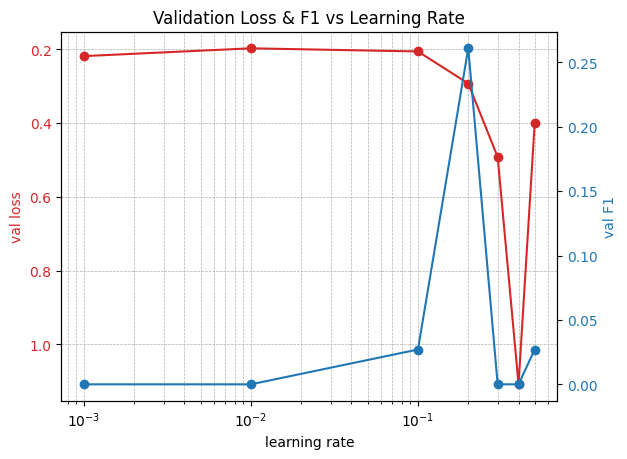

In [ ]:
lrs = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.001]
lrss, val_losses, val_f1s = logisticRegression.lr_grid_search(X_train, y_train, X_val, y_val, lrs, toPlot=True, iterations=500)

On peut voir que la meilleure balance offerte est autour d'un learning rate de . 

In [265]:
for lr, loss,f1 in zip(lrss, val_losses, val_f1s):
    print("Learning rate: " + str(lr) + " Loss: " + str(loss) + " F1: " + str(f1))

Learning rate: 0.2 Loss: 0.29278649121462386 F1: 0.2608695652173913
Learning rate: 0.1 Loss: 0.2058483415949312 F1: 0.02702702702702703
Learning rate: 0.03 Loss: 0.19499285634097774 F1: 0.0
Learning rate: 0.01 Loss: 0.1973399829248717 F1: 0.0
Learning rate: 0.003 Loss: 0.2070081463371732 F1: 0.0
Learning rate: 0.001 Loss: 0.21841396465912327 F1: 0.0
Learning rate: 0.0003 Loss: 0.2279159832163447 F1: 0.0
Learning rate: 0.0001 Loss: 0.23684267345563503 F1: 0.0


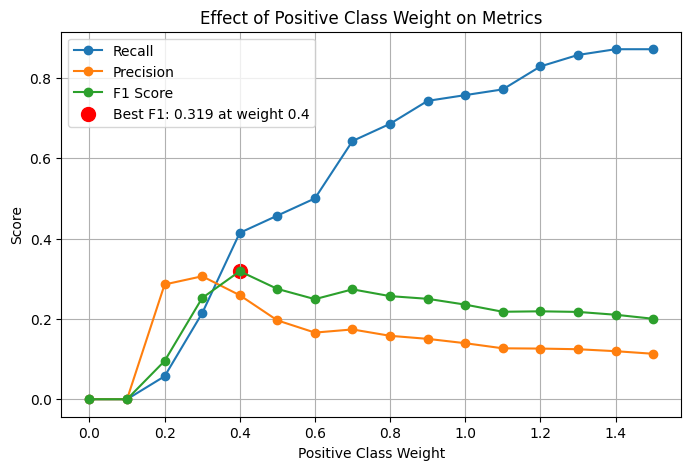

In [ ]:
weights_to_test = np.arange(0, 1.5 + 0.1, 0.1)
logisticRegression.plot_weights_effects(X_train_final_np, y_train_np, X_val_final_np, y_val_np, 0.5, ratio, weights_to_test, learning_rate=learning_rate)

In [ ]:
counts = np.bincount(y_train_np)
ratio = counts[0] / counts[1]

learning_rate=0.1

w,b = logisticRegression.logistic_regression(X_train_np, y_train_np, extra_weight=ratio, learning_rate=learning_rate)

Iteration 0: Cost = 1.3035216307952924


c:\Users\farou\OneDrive\Documents\data_projects\datasets\insurance\logisticRegression.py:7: RuntimeWarning: divide by zero encountered in log
  from itertools import combinations
c:\Users\farou\OneDrive\Documents\data_projects\datasets\insurance\logisticRegression.py:7: RuntimeWarning: invalid value encountered in multiply
  from itertools import combinations


Iteration 100: Cost = nan
Iteration 200: Cost = 50.96489901745818
Iteration 300: Cost = inf
Iteration 400: Cost = nan
Iteration 500: Cost = 52.75568805638762
Iteration 600: Cost = nan
Iteration 700: Cost = nan
Iteration 800: Cost = nan
Iteration 900: Cost = nan


KeyboardInterrupt: 

In [235]:
threshold = 0.1 #trop bas
model = Model.Model(w, b, threshold, improvement="adjusted weights")
tracker.add(model)

model.print_stats(X_val_np, y_val_np)

Model v11 saved

adjusted weights

Threshold:  0.1
Accuracy:  0.08240343347639485
[[  26 1069]
 [   0   70]]
AUC:  0.7884148727984346


C'est déja mieux, mais le threshold est trop bas. Je vais essayer 0.5

In [236]:
threshold = 0.5
model = Model.Model(w, b, threshold, improvement="adjusted weights")
tracker.add(model)

model.print_stats(X_val_np, y_val_np)

Model v12 saved

adjusted weights

Threshold:  0.5
Accuracy:  0.6815450643776824
[[741 354]
 [ 17  53]]
AUC:  0.7884148727984346


Beaucoup mieux, en plus avec un threshold de 0.5. Donc je croit, le modèle est asser précis maintenant. Je vais chercher le meilleur threshold.

In [222]:
threshold = logisticRegression.get_youden_threshold(X_val_np, y_val_np, w, b)
model = Model.Model(w, b, threshold, improvement="Youden index threshold")

YOUDEN_MODEL = "YoudenModel"
tracker.add(model, name=YOUDEN_MODEL, set_preferred=True)
model.print_stats(X_val_np, y_val_np)

Model YoudenModel existe deja, overriding...
Model YoudenModel saved

Youden index threshold

Threshold:  0.5638292284742521
Accuracy:  0.7570815450643776
[[832 263]
 [ 20  50]]
AUC:  0.7844618395303327


Au faite non, il n'est pas asser précis. Il a 313 False positive, donc il prédit 313 personnes comme ayant besoin d'assurance caravan en faite que non, ils ont pas besoin. En plus, il manque pas mal de personne (17) qui ont actually besoin d'une assurance caravan. 

In [223]:
data.top_index_and_values(15 ,corr_top)

Contribution car policies                          PPERSAUT   - 0.1637
Number of car policies                             APERSAUT   - 0.1495
Number of boat policies                            APLEZIER   - 0.1064
Contribution boat policies                         PPLEZIER   - 0.1064
Contribution fire policies                         PBRAND     - 0.1006
Average income                                     MINKGEM    - 0.1002
Contribution private third party insurance see L4  PWAPART    - 0.0953
Purchasing power class                             MKOOPKLA   - 0.0947
Number of private third party insurance 1 - 12     AWAPART    - 0.0900
Home owners                                        MHKOOP     - 0.0799
High level education                               MOPLHOOG   - 0.0782
1 car                                              MAUT1      - 0.0734
Income 45-75.000                                   MINK4575   - 0.0699
Number of fire policies                            ABRAND     - 0.0695
Number

On voit que PPERSAUT & APERSAUT sont les variables qui corrèles le plus avec CARAVAN, ce qui fais du sens puisque pour utiliser une Caravan, il faut au minimum une voiture pour la remorquer. 
- Donc, je pourrais indiquer à mon modèle qui si la personne a aucune voiture, alors c'est un "pas besoin d'assurance caravan" ou tout simplement les retirer du dataset. (C'est mieux de pas retirer, car sinon il pourrait miss des patterns et mal classifiés des personnes plus tard)

De plus, APLEZIER, PPLEZIER et PBRAND nous dit que les personnes qui ont des caravans sont des personnes avec un bon income, c'est surtout des clients disposant d’un pouvoir d’achat élevé.
- Donc, s'il y a moyen, peut-etre d'indiquer au modèle de faire plus attention a eux?

Je peux ajouter des "interaction terms". Pour PPERSAUT et APERSAUT c'est parfait puisque l'effet de PPERSAUT sur la probabilité d'avoir besoin d'une assurance caravan, dépend de APERSAUT (ou en d'autre mots dépend du nombre de car policies).

In [295]:
vars_to_test = [
    'PPERSAUT',   # Contribution car policies
    'APERSAUT',   # Number of car policies
    'APLEZIER',   # Number of boat policies
    'PPLEZIER',   # Contribution boat policies
    'PBRAND',     # Contribution fire policies
    'MINKGEM',    # Average income
    'PWAPART',    # Contribution private third party insurance see L4 
    'MKOOPKLA',   # Purchasing power class
    'AWAPART',    # Number of private third party insurance 1 - 12 
    'MHKOOP'      # Home owners
]

logisticRegression.interactions_terms_tester(X_train, y_train_np, w, b, vars_to_test=vars_to_test, learning_rate=0.005, ratio=ratio)

Interaction PPERSAUT_x_APERSAUT : AUC = 0.7559 (gain = +0.0010)
Interaction PPERSAUT_x_APLEZIER : AUC = 0.7606 (gain = +0.0057)
Interaction PPERSAUT_x_PPLEZIER : AUC = 0.7604 (gain = +0.0055)
Interaction PPERSAUT_x_PBRAND : AUC = 0.7599 (gain = +0.0050)
Interaction PPERSAUT_x_MINKGEM : AUC = 0.7551 (gain = +0.0002)
Interaction PPERSAUT_x_PWAPART : AUC = 0.7568 (gain = +0.0020)
Interaction PPERSAUT_x_MKOOPKLA : AUC = 0.7550 (gain = +0.0001)
Interaction PPERSAUT_x_AWAPART : AUC = 0.7560 (gain = +0.0011)
Interaction PPERSAUT_x_MHKOOP : AUC = 0.7562 (gain = +0.0013)
Interaction APERSAUT_x_APLEZIER : AUC = 0.7552 (gain = +0.0003)
Interaction APERSAUT_x_PPLEZIER : AUC = 0.7562 (gain = +0.0014)
Interaction APERSAUT_x_PBRAND : AUC = 0.7593 (gain = +0.0044)
Interaction APERSAUT_x_MINKGEM : AUC = 0.7553 (gain = +0.0004)
Interaction APERSAUT_x_PWAPART : AUC = 0.7568 (gain = +0.0019)
Interaction APERSAUT_x_MKOOPKLA : AUC = 0.7550 (gain = +0.0001)
Interaction APERSAUT_x_AWAPART : AUC = 0.7555 (gain

Je vais commencer par ajouter tout les interactions qui ont au minimum +0.003 de gain. 
Donc, PPERSAUT_x_APLEZIER, PPERSAUT_x_PPLEZIER, PPERSAUT_x_PBRAND, APERSAUT_x_PBRAND, PPLEZIER_x_MINKGEM, PPLEZIER_x_MKOOPKLA, PPLEZIER_x_MHKOOP.

In [224]:
interactions_to_add_1 = [
    ("PPERSAUT", "APLEZIER"),
    ("PPERSAUT", "PPLEZIER"),
    ("PPERSAUT", "PBRAND"),
    ("APERSAUT", "PBRAND"),
    ("APLEZIER", "MINKGEM"),
    ("APLEZIER", "MHKOOP"),
    ("PPLEZIER", "MINKGEM"),
    ("PPLEZIER", "MKOOPKLA"),
    ("PPLEZIER", "MHKOOP"),
]

X_train_final = data.add_interactions_terms(X_train, interactions_to_add_1)
X_val_final = data.add_interactions_terms(X_val, interactions_to_add_1)

X_train_final_np = X_train_final.to_numpy()
X_val_final_np = X_val_final.to_numpy()

prev_model = tracker.get_by_name(YOUDEN_MODEL)

model = Model.create_model(X_train_final_np, y_train_np, X_val_final_np, y_val_np, improvement="Added interactions terms with auc gain > 0.003", extra_weight=ratio, learning_rate=learning_rate, threshold_method="Youden")
print("With training set :")
logisticRegression.compare_auc_score(X_train_np, y_train_np, X_train_final_np, prev_model, model)

With training set :
New X : AUC = 0.7863 (gain = +0.0111)


Les intéractions ont ajoutés un gain d'AUC considérable (+1.24%)! Je vais faire un overfitting test pour voir s'il suraprenti pas.


In [225]:
X_train_interaction_1 = X_train_final
X_val_interaction_1 = X_val_final
logisticRegression.compare_model_stats(X_val_np, y_val_np, prev_model, model, X_val_final_np, isValData=True)

(Avec val data)

Old model :
Youden index threshold

Threshold:  0.23538129822899068
Accuracy:  0.7656652360515022
[[842 253]
 [ 20  50]]
AUC:  0.7808610567514676

New model :
Added interactions terms with auc gain > 0.003

Threshold:  0.40544097808164664
Accuracy:  0.7356223175965665
[[803 292]
 [ 16  54]]
AUC:  0.7797390737116765


<s>Sur le val data, les deux modèles détectent presque autant de vrais acheteurs. Par contre le nouveau modèle est considérablement plus précis en général. Je crois qu'il est plus avantageux de garder le nouveau modèle du au gain significatif de précision et que la perte des targets est seulement de 10.</s>

Maintenant, après avoir corrigé l'erreur d'utiliser le full training set pour évaluer et train le modèle et ensuite re-évaluer avec le test set. J'obtiens des résultats différents. Maintenant, le modèle est moins précis, mais son score AUC a augmenté d'environ 2%, donc il est plus facile pour lui de discriminer entre eux qui ont besoin d'assurance caravan vs eux que non. Malgré la perte de précision, je crois que dans ce cas si, c'est mieux de garder le nouveau modèle, car il discrimine mieux entre les targets et les non-targets.

In [226]:
INTER_TERMS_1_MODEL = "inter_terms_1" 
tracker.add(model, name=INTER_TERMS_1_MODEL, set_preferred=True)

Model inter_terms_1 saved



Maintenant, je vais voir si ajouter les interactions de termes qui ont un gain d'au moins 0.002 marche bien. Donc : PPERSAUT_x_PWAPART, APLEZIER_x_MKOOPKLA, APLEZIER_x_PPLEZIER

In [227]:
interactions_to_add_2 = [
    ('PPERSAUT', 'PWAPART'),
    ("APLEZIER", "MKOOPKLA"),
    ("APLEZIER", "PPLEZIER"),
]

X_train_final = data.add_interactions_terms(X_train_interaction_1, interactions_to_add_2)
X_train_final_np = X_train_final.to_numpy()

X_val_final = data.add_interactions_terms(X_val_interaction_1, interactions_to_add_2)
X_val_final_np = X_val_final.to_numpy()

prev_model = tracker.get_by_name(INTER_TERMS_1_MODEL)

model = Model.create_model(X_train_final_np, y_train_np, X_val_final_np, y_val_np, improvement="Added interactions terms with auc gain > 0.002", extra_weight=ratio, learning_rate=learning_rate, threshold_method="Youden")
logisticRegression.compare_auc_score(X_train_interaction_1.to_numpy(), y_train_np, X_train_final_np, prev_model, model)

New X : AUC = 0.7856 (gain = -0.0007)


In [228]:
INTER_TERMS_2_MODEL = "inter_terms_2" 
tracker.add(model, name=INTER_TERMS_2_MODEL)
logisticRegression.compare_model_stats(X_val_interaction_1.to_numpy(), y_val_np, prev_model, model, X_val_final_np, isValData=True)

Model inter_terms_2 saved

(Avec val data)

Old model :
Added interactions terms with auc gain > 0.003

Threshold:  0.40544097808164664
Accuracy:  0.7356223175965665
[[803 292]
 [ 16  54]]
AUC:  0.7797390737116765

New model :
Added interactions terms with auc gain > 0.002

Threshold:  0.34130497400121707
Accuracy:  0.7150214592274678
[[779 316]
 [ 16  54]]
AUC:  0.7769471624266145


<s> Le modèle augmente le rappel mais au cout de la précision. Je ne crois pas que sa vaut la peine, car la perte de précision est asser importante. </s>

<s>Les changements sont très faibles. Je ne vais pas ajouter les nouvelles intéractions pour éviter des complexifier le modèle inutilement. </s>

<s> Au faites, les changements sont faibles oui, mais pour le score AUC. Si on regarde la précision, il y eu un gain asser important. Environ (+1.3% de précision) et il trouve 1 target de plus. Je crois que sa vaut la peine de garder les termes additionneles pour l'instant.</s>

Oops je crois j'ai inversé le "il trouve 1 target de plus", mais je crois que le gain en précision de 1.3% est un bon échange pour une perte de 1 target.

In [229]:
#À garder pour plus tard au cas ou.
X_train_interaction_2 = X_train_final_np
X_val_interaction_2 = X_val_final_np

tracker.set_preferred(INTER_TERMS_2_MODEL)
model.print_stats(X_val_final_np, y_val_np)

Model inter_terms_2 is now preferred.
Added interactions terms with auc gain > 0.002

Threshold:  0.34130497400121707
Accuracy:  0.7150214592274678
[[779 316]
 [ 16  54]]
AUC:  0.7769471624266145


Je vais ajouter un L2 regularization pour pénaliser l'overfitting (surapprentissage), car j'ai ajouté des interactions terms. De plus,  L2 regularization encourage les weights à réduire leur magnitude, ce qui va être utile vu que j'ai ajouté des weight au target caravan. Sa devrait rendre le modèle plus stable, mais sans réduire l'importance qu'il doit apporter aux targets.

Je dois trouver la valeure optimale pour lambda pour mon L2. Je vais procéder similairement aux interactions terms.

In [230]:
lambdas = np.logspace(-5, 1, 7)
#score AUC différent vs a compare stats?
best_lambda, best_auc = logisticRegression.find_best_lambda(lambdas, X_train_final_np, y_train_np, X_val_final_np, y_val_np)

Lambda: 1e-05, AUC: 0.807410
Lambda: 0.0001, AUC: 0.807410
Lambda: 0.001, AUC: 0.807410
Lambda: 0.01, AUC: 0.807410
Lambda: 0.1, AUC: 0.807410
Lambda: 1.0, AUC: 0.807384
Lambda: 10.0, AUC: 0.807423
Best lambda: 10.0


<s>Aucune différence pour les différentes valeurs de lambda. Je vais pas ajouter de L2 regularization pour l'instant.</s>

Un petit gain au score AUC pour lambda = 10, que je vais ajouter à mon modèle. La valeur élevé du lambda veut dire que le modèle reste stable et n'overfit pas trop, même avec un L2 regularization.

In [231]:
model = Model.create_model(X_train_final_np, y_train_np, X_val_final_np, y_val_np, learning_rate, extra_weight=ratio, improvement="Ajout du L2 reg", threshold_method="Youden", l2_reg=True, lambda_const=10, to_print=True)
MODEL_L2_BASE = "L2ModelBase"
tracker.add(model, name=MODEL_L2_BASE, set_preferred=True)

Iteration 0: Cost = 0.6931471805599452
Iteration 100: Cost = 0.34795559042079094
Iteration 200: Cost = 0.35642004763968727
Iteration 300: Cost = 0.361839017411914
Iteration 400: Cost = 0.36572995798006447
Iteration 500: Cost = 0.3687817911723678
Iteration 600: Cost = 0.371342167963874
Iteration 700: Cost = 0.37359562281315273
Iteration 800: Cost = 0.37564597971090974
Iteration 900: Cost = 0.37755474226935276
Model L2ModelBase saved



In [232]:
prev_model = tracker.get_by_name(INTER_TERMS_2_MODEL)
logisticRegression.compare_model_stats(X_val_final_np, y_val_np, prev_model, model, isValData=True)

(Avec val data)

Old model :
Added interactions terms with auc gain > 0.002

Threshold:  0.34130497400121707
Accuracy:  0.7150214592274678
[[779 316]
 [ 16  54]]
AUC:  0.7769471624266145

New model :
Ajout du L2 reg

Threshold:  0.3405304402249028
Accuracy:  0.7150214592274678
[[779 316]
 [ 16  54]]
AUC:  0.7774559686888454


Pour optimiser mon modèle, je vais essayer de trouver un meilleur threshold avec le F1-score, car le F1-score est souvent utilisé pour les datasets imbalanced, donc lui présent.

In [233]:
f1_threshold, score_f1 = logisticRegression.f1_score_threshold(X_val_final_np, y_val_np, model.w ,model.b)
print("f1 threshold : ", f1_threshold)
print("f1 score     : ", score_f1)

f1 threshold :  0.62
f1 score     :  0.2773722627737226


In [117]:
model = Model.Model(model.w, model.b, f1_threshold, score_f1=score_f1, improvement="Added F1 score for finding best threshold (w/ Interactions terms 2)")
FIRST_F1_MODEL = "FirstF1Model"
tracker.add(model, name=FIRST_F1_MODEL)

Model FirstF1Model saved



In [118]:
model = tracker.get_by_name(FIRST_F1_MODEL)
prev_model = tracker.get_by_name(MODEL_L2_BASE)
logisticRegression.compare_model_stats(X_val_final_np, y_val_np, prev_model, model, isValData=True)

(Avec val data)

Old model :
Ajout du L2 reg

Threshold:  0.4578161927525435
Accuracy:  0.655793991416309
[[705 390]
 [ 11  59]]
AUC:  0.8018525766470972

New model :
Added F1 score for finding best threshold (w/ Interactions terms 2)

Threshold:  0.75
Accuracy:  0.9090128755364807
[[1035   60]
 [  46   24]]
AUC:  0.8018525766470972
F1:  0.3116883116883117


Le modèle est beaucoup plus accurate (presque 100%!), mais puisque le threshold est plus élevé, le modèle trouve moins de personne ayant besoin d'assurance caravan. Je vais garder le threshold du F1 score, car il rend le modèle beaucoup plus accurate. Je crois sa serait mieux de continuer de l'optimiser avec ce threshold.

Par contre le F1 score est d'environ 0.31 ce qui est pas très bon, il a encore du mal à prédire les targets.

Puisque j'ai changé au F1 score pour évaluer les performances et choisir le threshold. Je vais revisiter voir si le F1 score est affecter par les interactions terms

In [122]:
prev_model = tracker.get_by_name(INTER_TERMS_1_MODEL)

X_val_interaction_1

f1_threshold, score_f1 = logisticRegression.f1_score_threshold(X_val_interaction_1, y_val_np, prev_model.w, prev_model.b)
prev_model.threshold = f1_threshold
prev_model.score_f1 = score_f1
prev_model.improvement = "Interactions terms 1 with F1 threshold"

logisticRegression.compare_model_stats(X_val_interaction_1, y_val_np, prev_model, model, X_val_final_np, isValData=True)

(Avec val data)

Old model :
Interactions terms 1 with F1 threshold

Threshold:  0.71
Accuracy:  0.8892703862660944
[[1006   89]
 [  40   30]]
AUC:  0.8018395303326808
F1:  0.31746031746031744

New model :
Added F1 score for finding best threshold (w/ Interactions terms 2)

Threshold:  0.75
Accuracy:  0.9090128755364807
[[1035   60]
 [  46   24]]
AUC:  0.8018525766470972
F1:  0.3116883116883117


Le F1 score du modèle avec les interactions terms avec un gain d'auc >= 0.003 a un F1 score légèrement plus haut. Il trouve plus de target mais est moins précis. Je crois qu'il est mieux de garder le modèle avec les interactions terms avec un gain d'auc minimum de 0.003, car le gain en précision avec l'ajout des interactions terms avec un gain d'auc minimum de 0.002 ne vaut pas la perte des targets.

In [123]:
INTER_TERMS_1_F1_MODEL = "InterTerms1F1Model"
tracker.add(prev_model, name=INTER_TERMS_1_F1_MODEL)
tracker.set_preferred(INTER_TERMS_1_F1_MODEL)
model = tracker.get_by_name(INTER_TERMS_1_F1_MODEL)

X_train_final = X_train_interaction_1
X_val_final = X_val_interaction_1
X_train_final_np = X_train_final.to_numpy()
X_val_final_np = X_val_final.to_numpy()
model.print_stats(X_val_final_np, y_val_np)

Model InterTerms1F1Model saved

Model InterTerms1F1Model is now preferred.
Interactions terms 1 with F1 threshold

Threshold:  0.71
Accuracy:  0.8892703862660944
[[1006   89]
 [  40   30]]
AUC:  0.8018395303326808
F1:  0.31746031746031744


Je vais utiliser des steps plus petit pour maximiser le F1 score et pour trouver un encore plus meilleur threshold.

In [124]:
f1_threshold, score_f1 = logisticRegression.f1_score_threshold(X_val_final_np, y_val_np, model.w, model.b, step=0.001)
model.threshold = f1_threshold
model.score_f1 = score_f1
model.print_stats(X_val_final_np, y_val_np)

Interactions terms 1 with F1 threshold

Threshold:  0.719
Accuracy:  0.8952789699570816
[[1013   82]
 [  40   30]]
AUC:  0.8018395303326808
F1:  0.32967032967032966


Nice, je ne croyais pas sa allais avoir un méga impact, mais quand même! Le threshold légèrement plus élevé lui a permis de réduire le nombre de false positive, mais le nombre de targets détecté reste inchangé. Je crois que je vais devoir refaire cette évaluation plus tard si j'ajoute d'autre truc au modèle. 

In [125]:
F1_OPT_MODEL_1 = "InterTerms1OptimizedF1"
model.improvement = "Added optimized F1"
tracker.add(model, name=F1_OPT_MODEL_1)

Model InterTerms1OptimizedF1 saved



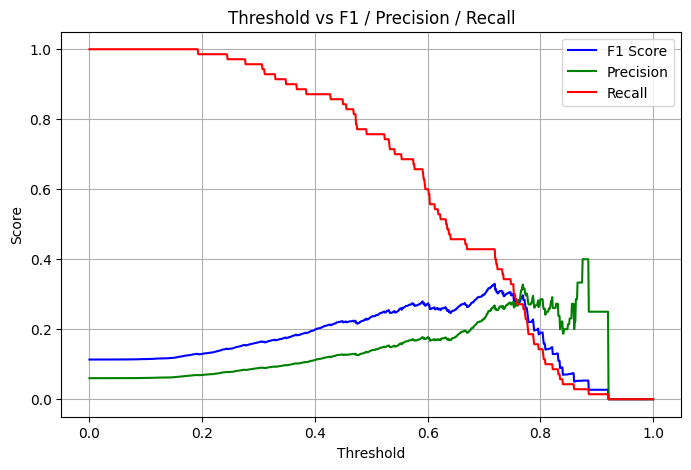

In [ ]:
#Rappel:
#Precision est overall precision. 
#Recall est la proportion des vrais targets trouvés (trouvé/(trouvé + non-trouvé))
#F1 score est une balance entre la précision et le recall. 

logisticRegression.plot_threshold_metrics(model, X_val_final_np, y_val_np, step=0.001)

Ah mais nn qu'est ce que je fais lol. Je dois continuer a optimizer le modèle au lieu d'optimiser le threshold et tout sa parce que sa ne va pas réellement améliorer le modèle. Je fais juste changer le t h r e s h o l d. Donc le seul truc qui est affecter est comment le modèle classe ses prédictions, il ne prédit pas mieux ou moins bien en modifiant les thresholds. Je vais retourner a un threshold basique de 0.5 et continuer d'amélioration les prédictions du modèles et quand j'ai fini, là je vais check a optimiser le threshold.

In [130]:
model = tracker.get_by_name(INTER_TERMS_1_MODEL)

BASE_INTER_TERMS_1 = "BaseInterTerms1"
model.threshold = 0.5
model.print_stats(X_val_final_np, y_val_np)
tracker.add(model, BASE_INTER_TERMS_1)

Added interactions terms with auc gain > 0.003

Threshold:  0.5
Accuracy:  0.7047210300429184
[[768 327]
 [ 17  53]]
AUC:  0.8018395303326808
Model BaseInterTerms1 saved



Je vais expérimenter avec des poids de plus.

In [ ]:
model = Model.create_model_v2(X_train_final_np, y_train_np, X_val_final_np, y_val_np, learning_rate=learning_rate, extra_weight=ratio, improvement="Added extra weights to the cost function", to_print=True)
model.print_stats(X_val_final_np, y_val_np)


Iteration 0: Cost = 1.3035216307952924
Iteration 100: Cost = 1.1406988405380174
Iteration 200: Cost = 1.1225356090413017
Iteration 300: Cost = 1.112269191347845
Iteration 400: Cost = 1.1052935073054295
Iteration 500: Cost = 1.100058808420506
Iteration 600: Cost = 1.0958929422631138
Iteration 700: Cost = 1.092447616849225
Iteration 800: Cost = 1.0895185758833894
Iteration 900: Cost = 1.0869756513922388
Added extra weights to the cost function

Threshold:  0.5
Accuracy:  0.7047210300429184
[[768 327]
 [ 17  53]]
AUC:  0.8018395303326808


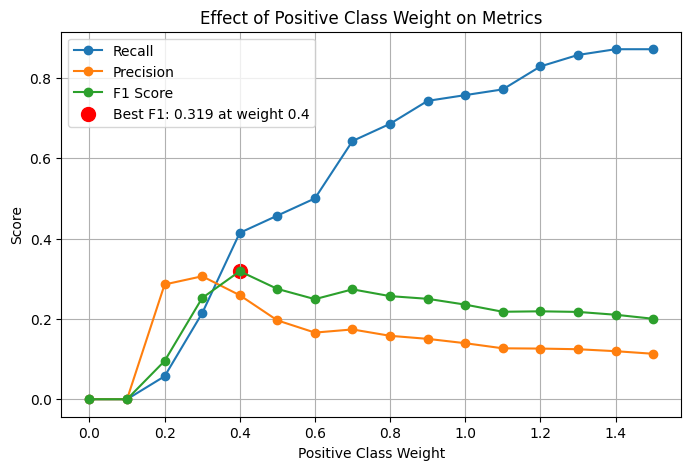

In [168]:
weights_to_test = np.arange(0, 1.5 + 0.1, 0.1)
logisticRegression.plot_weights_effects(X_train_final_np, y_train_np, X_val_final_np, y_val_np, 0.5, ratio, weights_to_test, learning_rate=learning_rate)

In [135]:
print(ratio)

15.748201438848922
